In [1]:
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import math
import sys
import time

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import mapclassify as mc
import seaborn as sns

from pathlib import Path
import requests,json

In [2]:
CM = 1/2.54
DEBUG = True
copyright2 = "Datenquellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0"
overview = ['Deutschland', 'Bayern', 'SK München']
today = datetime.today().strftime('%y%m%d')

# Link to RKI Cocid Database
covid_url = \
'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'

In [3]:
covid_file = today + "_RKI_COVID19.csv"
covid_path=Path(covid_file)
if not covid_path.is_file():
    print('Getting new Covid Data for ', today)
    r = requests.get(covid_url, allow_redirects=True)
    filesize = open(covid_path, 'wb').write(r.content)
    print('Done!')
else:
    print('Using existing file ', covid_file)

Getting new Covid Data for  220104
Done!


In [4]:
# Load the covid database via pd.read_csv()

covid = pd.read_csv(covid_file, parse_dates=['Meldedatum'])

start=covid['Meldedatum'].min()
ende=covid['Meldedatum'].max()

landkreise=covid['Landkreis'].unique()
bundeslaender=covid['Bundesland'].unique()

if DEBUG:
    print('Start Erfassung:', start.strftime('%d.%m.%Y')) 
    print('Ende  Erfassung:', ende.strftime('%d.%m.%Y'))
    print('Anzahl Bundesländer:', len(bundeslaender))
    print('Anzahl Landkreise:', len(landkreise))

Start Erfassung: 02.01.2020
Ende  Erfassung: 03.01.2022
Anzahl Bundesländer: 16
Anzahl Landkreise: 411


In [5]:
# Geopandas datafiles, Bundesland und Kreise

bland_path = 'vg2500_geo84/vg2500_bld.shp'
bland = gpd.read_file(bland_path)

kreise_path = 'RKI_Corona_Landkreise/RKI_Corona_Landkreise.shp'
kreise = gpd.read_file(kreise_path)

ewz=pd.DataFrame(kreise)

#Einwohnerzahlen Bundesländer und Landkreise

bl=ewz.groupby('BL').EWZ_BL.max()
lk=ewz.groupby('county').EWZ.max()

summe_ew_deutschland = bl.sum()

#Tabelle der Einwohnerzahlen von Landkreisen, Bundesländern und Deutschland gesamt

einwohner=pd.concat([lk,bl])
einwohner.loc['Deutschland']=summe_ew_deutschland

if DEBUG:
    print('Einwohner Deutschland:', summe_ew_deutschland)

Einwohner Deutschland: 83155031


In [6]:
# Main grouping steps for Landkreise, Bundesländer und Deutschland gesamt

Faelle_lk = covid.groupby(['Landkreis', 'Meldedatum']).AnzahlFall.sum()
Faelle_bl = covid.groupby(['Bundesland', 'Meldedatum']).AnzahlFall.sum()
Faelle_d  = covid.groupby('Meldedatum').AnzahlFall.sum()

# Generate luist for every day of the pandemic and create an empty dataframe with it

tagesliste = pd.date_range(start,ende)
result=pd.DataFrame(index=tagesliste)

lk_auswahl=landkreise
for i in lk_auswahl:
    tmp=Faelle_lk[i]
    result = pd.concat([result, tmp.rename(i)], axis=1)

bl_auswahl=bundeslaender
for i in bl_auswahl:
    tmp=Faelle_bl[i]
    result = pd.concat([result, tmp.rename(i)], axis=1)
    
result = pd.concat([result,Faelle_d.rename('Deutschland')], axis=1)


#Rollierende 7 Tage Mittelwerte und Summationen    
    
result.fillna(value=0, inplace=True)
result_m7 = result.rolling(7).mean()
result_s7 = result.rolling(7).sum()

# Inzidenz berechnen:

for i in result_s7.columns:
    result_s7[i] = result_s7[i]*100000/ float(einwohner.loc[i])

# Zeitliche Änderung der Inzidenzen berechnen:

dinz_dt = pd.DataFrame(
    {'INZ': result_s7.iloc[-1], 
     'DINZ1': (result_s7.iloc[-1] - result_s7.iloc[-2])/result_s7.iloc[-2]*100,
     'DINZ7': (result_s7.iloc[-1] - result_s7.iloc[-8])/result_s7.iloc[-8]*100, 
    'MELD': result.iloc[-1]}
)

top3=dinz_dt.sort_values(by='DINZ7').iloc[-3:]
top5=dinz_dt.sort_values(by='DINZ7').iloc[-5:]

inztop5=dinz_dt.sort_values(by='INZ').iloc[-5:]
        
# County Bezeichnungen, Inzidenzen und Delta-Inzidenzen zum gpd File dazumergen

tmpkreise = kreise.copy()
tmpdinzdt=dinz_dt.reset_index()

tmpdinzdt.rename(columns={'index':'county'}, inplace=True)
tmpkreise=pd.merge(tmpkreise, tmpdinzdt, on='county', how='left')


if DEBUG:
    print('Überblick')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in overview:
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)
    print('\nTop Änderungen')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in list(top3.index):
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)
        
    print('\nTop Inzidenzen')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in list(inztop5.index):
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)

Überblick
Inzidenz 	 Neue Fälle 	 Kreis
239.5 		 20769 		 Deutschland
199.4 		 2845 		 Bayern
216.9 		 492 		 SK München

Top Änderungen
Inzidenz 	 Neue Fälle 	 Kreis
345.0 		 16 		 LK Rendsburg-Eckernförde
357.4 		 58 		 LK Sankt Wendel
375.7 		 52 		 LK Nordfriesland

Top Inzidenzen
Inzidenz 	 Neue Fälle 	 Kreis
549.0 		 106 		 LK Hildburghausen
559.7 		 410 		 SK Erfurt
568.5 		 411 		 SK Bremen
635.6 		 79 		 LK Dithmarschen
643.9 		 1 		 LK Ilm-Kreis


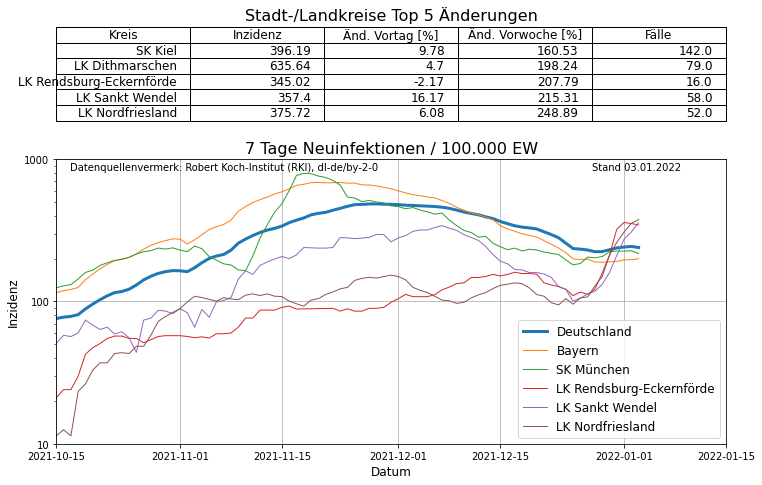

In [7]:
fig, axs = plt.subplots(2,1, figsize=(12.,7.68),gridspec_kw={'height_ratios': [1, 3]})
top=top5.reset_index()
top=top.round(2)

table = axs[0].table(cellText=top.values, 
                     colLabels=["Kreis","Inzidenz","Änd. Vortag [%]", 
                                "Änd. Vorwoche [%]", "Fälle"], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1,1.3)


axs[0].axis('off')
axs[0].set_title('Stadt-/Landkreise Top 5 Änderungen', fontsize=16)

#fig.subplots_adjust(hspace=.001)

#cx=fig.add_subplot(1,1,1)

axs[1].grid()
a=axs[1].set_title('7 Tage Neuinfektionen / 100.000 EW',fontsize=16)
b=axs[1].set_xlabel('Datum', fontsize=12)
c=axs[1].set_ylabel('Inzidenz', fontsize=12)


for i in overview:
    if i == 'Deutschland':
        lw=3
    else:
        lw = 1
    axs[1].plot(result_s7[i], label=i, linewidth=lw)
    
for i in top3.index:
    axs[1].plot(result_s7[i], label=i, linewidth=lw)
    


e=axs[1].set_xlim([datetime(2021,10,15),datetime(2022,1,15)])
f=axs[1].set_yscale('log')

g=axs[1].set_ylim([10,1000])
#axs[1].set_yticks([1, 10, 100, 1000])
axs[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
h=axs[1].legend(loc='best', fontsize=12)
axs[1].text(0.02,.96,copyright2, transform=axs[1].transAxes)

txt='Stand '+ ende.strftime('%d.%m.%Y')
axs[1].text(.8,.96,txt, transform=axs[1].transAxes)

inzplotfile=ende.strftime('%y%m%d')+'_Inzidenzen.png'
fig.savefig(inzplotfile, dpi=100)

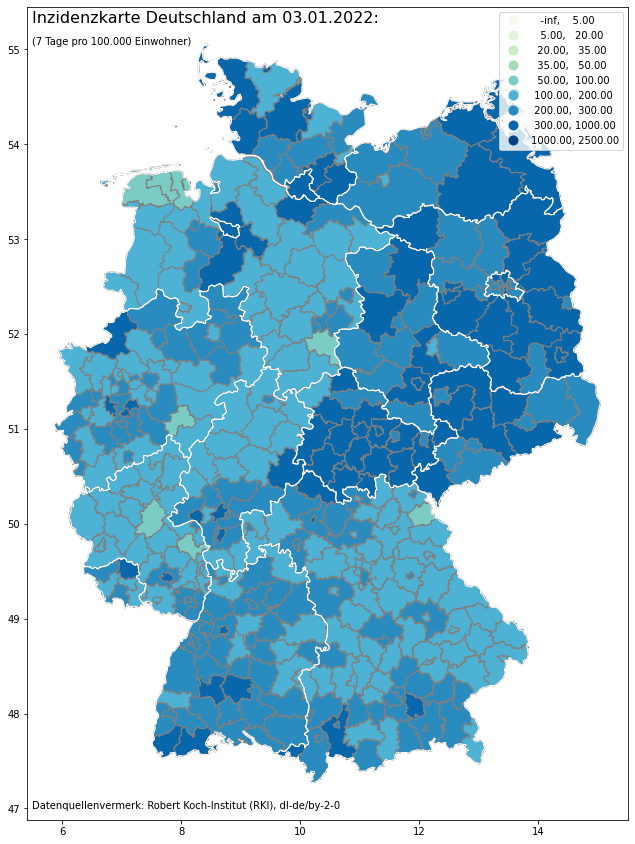

In [8]:
#Mainplot mit Bundeslandgrenzen

cm=1/2.54
fig, ax = plt.subplots(1,1, figsize=(60*cm, 38*cm))

#ax = tmpkreise.plot(figsize=(15,15), edgecolor='grey', column='INZ', cmap='tab10', scheme='MaximumBreaks', legend=True)
#ax = tmpkreise.plot(figsize=(15,15), edgecolor='grey', column='INZ', cmap='tab10', scheme='Quantiles', legend=True)


bins1 =[5, 20, 35, 50, 100, 200, 300, 1000, 2500]
px1 = tmpkreise.plot(ax=ax, edgecolor='grey', column='INZ', cmap='GnBu', 
                    scheme='UserDefined', classification_kwds={'bins': bins1},
                    legend=True)

px2=bland.plot(ax=ax, edgecolor='white', color='none')


txt="Inzidenzkarte Deutschland "
end_str=ende.strftime('%d.%m.%Y')
txt += ("am " + end_str + ':\n')
cx=ax.text(5.5,55.1, txt,fontsize=16)

txt="(7 Tage pro 100.000 Einwohner)"
dx=ax.text(5.5,55.05,txt)


ex=ax.text(5.5,47,copyright2)

pre_str=ende.strftime('%Y%m%d')
diagram_file=pre_str+"_Inzidenzkarte_Deutschland"
plt.savefig(diagram_file, dpi=300)

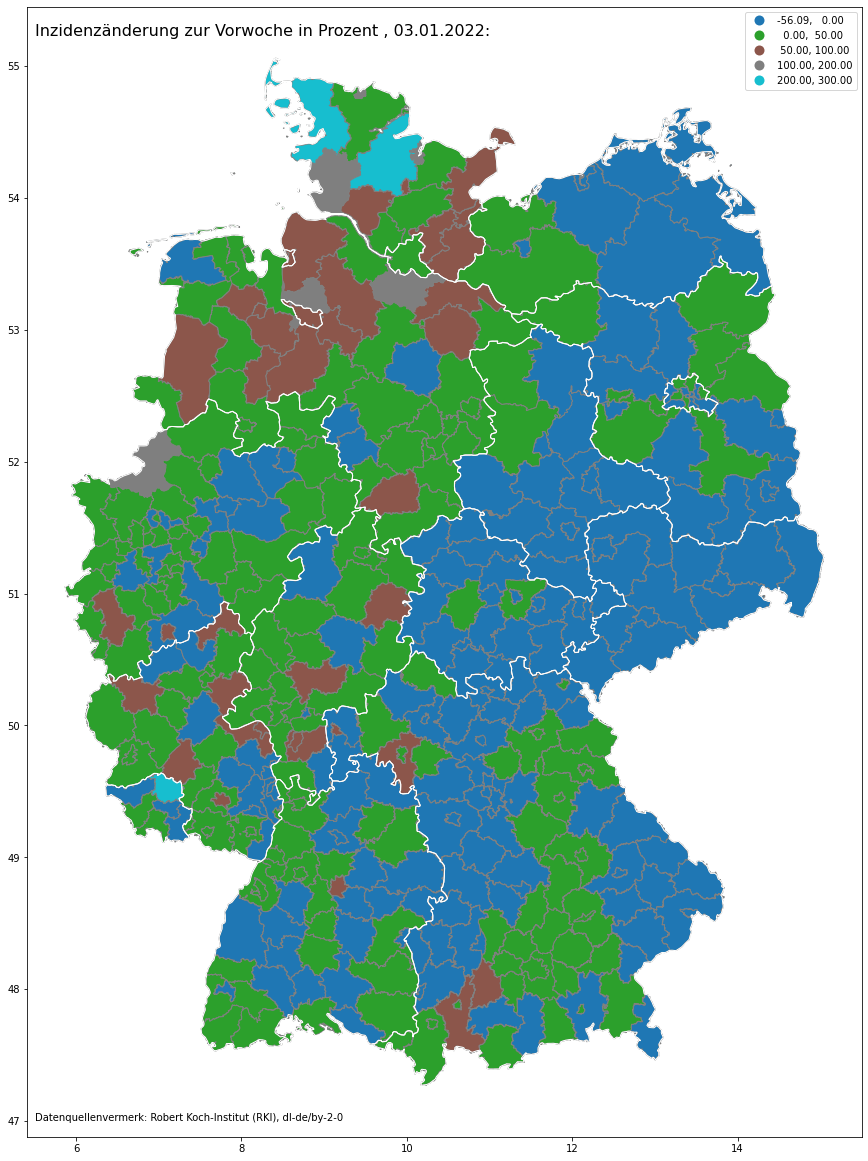

In [9]:
# Delta inzidenzen

fig = plt.figure(figsize=(38*CM, 60*CM))

bx=fig.add_subplot(1, 1, 1)
#dbins =[-100, -50, 0, 50, 100, 200]
dbins =[0, 50, 100, 200, 300]
px3 = tmpkreise.plot(ax=bx, edgecolor='grey', column='DINZ7', cmap='tab10', 
                    scheme='UserDefined', classification_kwds={'bins': dbins},
                    legend=True)

px4=bland.plot(ax=bx, edgecolor='white', color='none')

txt="Inzidenzänderung zur Vorwoche in Prozent "
end_str=ende.strftime('%d.%m.%Y')
txt += (", " + end_str + ':\n')
cx=bx.text(5.5,55.1, txt,fontsize=16)


copyright2 = "Datenquellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0"
ex=bx.text(5.5,47,copyright2)


pre_str=ende.strftime('%Y%m%d')
diagram_file=pre_str+"_Delta-Inzidenzkarte_Deutschland"
plt.savefig(diagram_file, dpi=300)

In [10]:
# Top Änderungen zu gestern und zu vor 7 Tagen

deltas1=tmpkreise[['county','DINZ1']].set_index('county').DINZ1
deltas7=tmpkreise[['county','DINZ7']].set_index('county').DINZ7

#Statistics
m1=deltas1.mean()
neg1=len(deltas1[deltas1<0])
pos1=len(deltas1[deltas1>=0])

m7=deltas7.mean()
neg7=len(deltas7[deltas7<0])
pos7=len(deltas7[deltas7>=0])

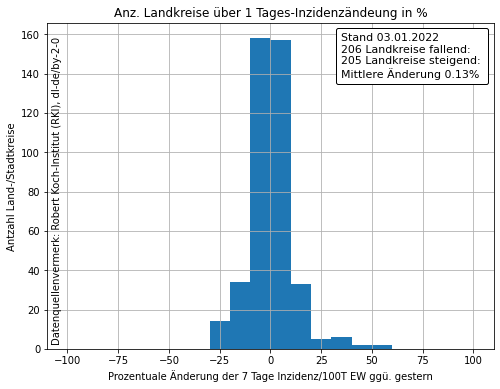

In [11]:
#Histogramm (Gestern)

fig, ax= plt.subplots(1,1,figsize=(8,6))

#hp=deltas.hist(bins=40)
deltas1.hist(
    ax=ax, bins=[-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100])

ax.set_ylabel('Antzahl Land-/Stadtkreise')
ax.set_xlabel('Prozentuale Änderung der 7 Tage Inzidenz/100T EW ggü. gestern')

ax.set_title('Anz. Landkreise über 1 Tages-Inzidenzändeung in %')

ax.text(.01,.02,copyright2, rotation=90, transform=ax.transAxes)

Summary1 = 'Stand '+ ende.strftime('%d.%m.%Y') \
+ '\n' + str(neg1) + ' Landkreise fallend: ' \
+ '\n' + str(pos1) + ' Landkreise steigend: ' \
+ '\nMittlere Änderung ' \
+ '{:.2f}'.format(m1) + '%'


at = AnchoredText(
    Summary1, prop=dict(size=11), frameon=True, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)



histplotfile1=ende.strftime('%y%m%d')+' Histogramm1Tag.png'
fig.savefig(histplotfile1, dpi=100)

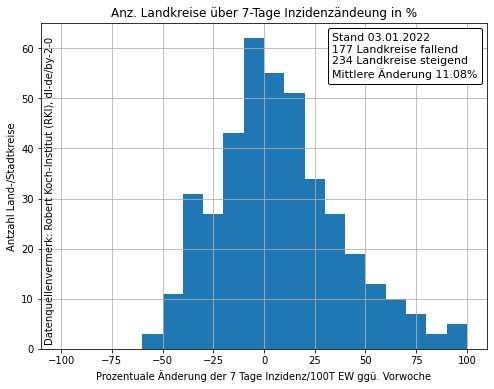

In [12]:
#Histogramm (7 Tage)

fig, bx = plt.subplots(1,1,figsize=(8,6))

#hp=deltas.hist(bins=40)
deltas7.hist(
    ax=bx, bins=[-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100])

bx.set_ylabel('Antzahl Land-/Stadtkreise')
bx.set_xlabel('Prozentuale Änderung der 7 Tage Inzidenz/100T EW ggü. Vorwoche')

bx.set_title('Anz. Landkreise über 7-Tage Inzidenzändeung in %')

bx.text(.01,.02,copyright2, rotation=90, transform=bx.transAxes)

Summary7 = 'Stand '+ ende.strftime('%d.%m.%Y') \
+ '\n' + str(neg7) + ' Landkreise fallend ' \
+ '\n' + str(pos7) + ' Landkreise steigend ' \
+ '\nMittlere Änderung ' + '{:.2f}'.format(m7) + '%'

at = AnchoredText(
    Summary7, prop=dict(size=11), frameon=True, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bx.add_artist(at)

histplotfile7=ende.strftime('%y%m%d')+' Histogramm7.png'
fig.savefig(histplotfile7, dpi=100)

In [13]:
xyz=result.iloc[-1]
xy=xyz.value_counts()
xy=xy.sort_index()
xy.head()

0.0    19
1.0    11
2.0     2
3.0    14
4.0     7
Name: 2022-01-03 00:00:00, dtype: int64

In [ ]:
### Debug and test section

In [ ]:
#ewz[ewz['county'].str.contains('Würz')]

In [ ]:
result['SK München'].tail(20)